In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics

from Experiments import get_setup

from Inference.IVI_PAC import IVI

from tqdm import trange

import timeit

In [3]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5



#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

# Setup #

In [5]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='yacht' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

#sigma_noise=#setup.sigma_noise

sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
print(size_data)
#batch_size
batch_size=30#int(np.min([size_data/6,500]))
if dataset=='powerplant':
    batch_size=50

n_samples_FU=30 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=30#30 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

277


# Predictive model #

In [6]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

param_count

401

# ELBO

## Truncated square loss

In [7]:
def MarginalMeanSquareError(x_data, y_data, GeN,M):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    assert y_pred.shape[1] == y_data.shape[0]
    assert y_pred.shape[2] == y_data.shape[1]
    assert y_data.shape[1] == 1
    B = y_pred.shape[0]
    S = y_pred.shape[1]
    d = (y_pred.view(B, S, 1) - y_data.view(1, S, 1)) ** 2 
    percentage=100*(d >=M).float().sum().item()/len(d.flatten())
    if percentage > 1.:
        print(str(percentage)+'% predictions out of bound, you may want to increase the bound M')
    d.clamp(0.,M)/M
    
    return d.mean()



## Kullback-Leibler divergence in Predictor space

In [8]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
    epsilon=0.1
    M = x_train.max(0, keepdim=True)[0]+epsilon
    m = x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj


#prior on parameters of predictive model

def prior(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)


def kl(x_data, GeN, beta):
    
    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device, beta=beta)
    return K

def precise_kl(train_loader, GeN, beta):
    Ks=[]
    for x_data,y in train_loader:
        theta=GeN(n_samples_KL) #variationnel
        theta_prior=prior(n_samples_KL) #prior

        theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

        Ks.append(KL(theta_proj, theta_prior_proj,k=kNNE,device=device, beta=1.0))
    return torch.as_tensor(Ks).mean()


def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [9]:
#ELBO
 #KL regularizer
M=20.    
beta=1.
def ELBO(x_data, y_data, GeN, C):
    delta=0.05
#    Average_MSE=loss(x_data, y_data, GeN,M)
    the_KL=kl(x_data, GeN, beta)
    loss=MarginalMeanSquareError(x_data, y_data, GeN,M)
    the_ELBO=  C*loss+ (1 / len(x_data))* (the_KL+math.log(2 * math.sqrt(len(x_data)) / delta))#(len(x_data)/size_data)*the_KL
    return the_ELBO, the_KL, loss 

def PACBound(train_loader, x_data, y_data, GeN, C):
    delta=0.05
#    Average_MSE=loss(x_data, y_data, GeN,M)
    the_KL=precise_kl(train_loader, GeN, beta)
    loss=MarginalMeanSquareError(x_data, y_data, GeN,M)
    L=  C*loss+ (1 / len(x_data))* (the_KL+math.log(2 * math.sqrt(len(x_data)) / delta))
    B=(1-torch.exp(-L))/(1-torch.exp(-C))
    return (1-torch.exp(-L))/(1-torch.exp(-C))


# Generative model #

In [10]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=401, bias=True)
  )
)


In [11]:
MarginalMeanSquareError(x_train, y_train, GeN,M)

tensor(1.3522, device='cuda:0', grad_fn=<MeanBackward0>)

# Catoni's temperature #

In [12]:
C=torch.tensor(30.)
_C=torch.log(torch.exp(C)-1).clone().to(device).detach().requires_grad_(True)
optimizer_temp=torch.optim.Adam([_C],lr=0.1)
sigma_noise=(M/(2*C.clone().detach())).sqrt()
print('sigma_noise: '+str(sigma_noise))

sigma_noise: tensor(0.5774)


# Optimizer

In [13]:
#optimizer
learning_rate=0.01

optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [14]:
#scheduler
patience=25
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=2000#2000

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [ ]:
KLs=[]
ELBOs=[]
LRs=[]
LLs=[]
Ts = []
Bs=[]
test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        C = torch.log(torch.exp(_C) + 1.)
        sigma_noise=(M/(2*C.detach())).sqrt()
        theta=GeN(1000).detach()
        metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise.cpu(), std_y_train, device='cpu', std=False)
#        metrics.update({'KL_train': kl_train(GeN,x_train[:500]).item()})
#        metrics.update({'HMC_OOD': kl_HMC_OOD(GeN).item()})
#        metrics.update({'HMC_train': kl_HMC_train(GeN,x_train[:500]).item()})
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        GeN.requires_grad_(True)
        scores=Run.run(GeN,C.detach())
        
        scheduler.step(scores['ELBO'])

        optimizer_temp.zero_grad()
        GeN.requires_grad_(False)
        B=PACBound(train_loader, x_train, y_train, GeN, C)
        B.backward()
        optimizer_temp.step()
        
        
        tr.set_postfix(Bound=B.item(),Temp=C.item(),ELBO=scores['ELBO'], Loss=scores['LOSS'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LOSS'])
        LRs.append(scores['lr'])
        Ts.append(C.item())
        Bs.append(B.item())
        if scores['lr'] < 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 10%|█         | 205/2000 [00:28<04:27,  6.70it/s, Bound=0.287, ELBO=2.1, KL=48.8, Loss=0.0255, Temp=8.34, lr=0.005] 

Epoch   204: reducing learning rate of group 0 to 5.0000e-03.


 12%|█▏        | 231/2000 [00:31<04:03,  7.27it/s, Bound=0.202, ELBO=1.78, KL=43.8, Loss=0.00998, Temp=5.45, lr=0.0025]

Epoch   230: reducing learning rate of group 0 to 2.5000e-03.


 31%|███       | 620/2000 [01:21<03:07,  7.35it/s, Bound=0.104, ELBO=0.892, KL=19.9, Loss=0.0031, Temp=3.02, lr=0.0025]  

Epoch   620: reducing learning rate of group 0 to 1.2500e-03.


 36%|███▌      | 716/2000 [01:35<03:00,  7.11it/s, Bound=0.0927, ELBO=0.833, KL=18.1, Loss=0.00361, Temp=3.47, lr=0.000625]

Epoch   715: reducing learning rate of group 0 to 6.2500e-04.


 38%|███▊      | 751/2000 [01:40<03:02,  6.83it/s, Bound=0.09, ELBO=0.807, KL=17.4, Loss=0.00278, Temp=3.41, lr=0.000313]  

Epoch   750: reducing learning rate of group 0 to 3.1250e-04.


 39%|███▉      | 777/2000 [01:44<02:55,  6.96it/s, Bound=0.09, ELBO=0.816, KL=17.6, Loss=0.00275, Temp=3.54, lr=0.000156]  

Epoch   776: reducing learning rate of group 0 to 1.5625e-04.


 40%|████      | 803/2000 [01:48<02:56,  6.78it/s, Bound=0.0904, ELBO=0.778, KL=16.6, Loss=0.00265, Temp=3.61, lr=0.0001]  

Epoch   802: reducing learning rate of group 0 to 1.0000e-04.


 90%|████████▉ | 1793/2000 [03:59<00:30,  6.77it/s, Bound=0.083, ELBO=0.728, KL=15.1, Loss=0.00171, Temp=3.94, lr=0.0001] 

# Results on test #

In [116]:
#compute metrics on test
C = torch.log(torch.exp(_C) + 1.)
sigma_noise=(M/(2*C.clone().detach())).sqrt().cpu()
print('sigma_noise: '+str(sigma_noise.item()))
results={}
log_device='cpu'
theta=GeN(2000).detach()
metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu')
results.update({dataset:metrics})
results[dataset].update({'Bound':M*Bs[-1],'time [s]':execution_time})

print('std_y_train: {}'.format(std_y_train.item()))
print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

sigma_noise: 1.613153338432312
std_y_train: 15.539651870727539
yacht
RMSE: (1.2174605131149292, 2.371533155441284)
LPP: (-1.3985402584075928, 0.004640659317374229)
PICP: 1.0
MPIW: 1.6536264419555664
Bound: 3.0438220500946045
time [s]: 261.9779364899732


In [117]:
#compute metrics on test

results={}
log_device='cpu'
theta=prior(2000).detach()
metrics_=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu')
results.update({dataset:metrics_})

print(dataset)
print("prior's scores")
for m, r in metrics_.items():
    print(m+': '+str(r))


yacht
prior's scores
RMSE: (15.119178771972656, 17.6302433013916)
LPP: (-3.4154210090637207, 0.2850039005279541)
PICP: 1.0
MPIW: 795.3984375


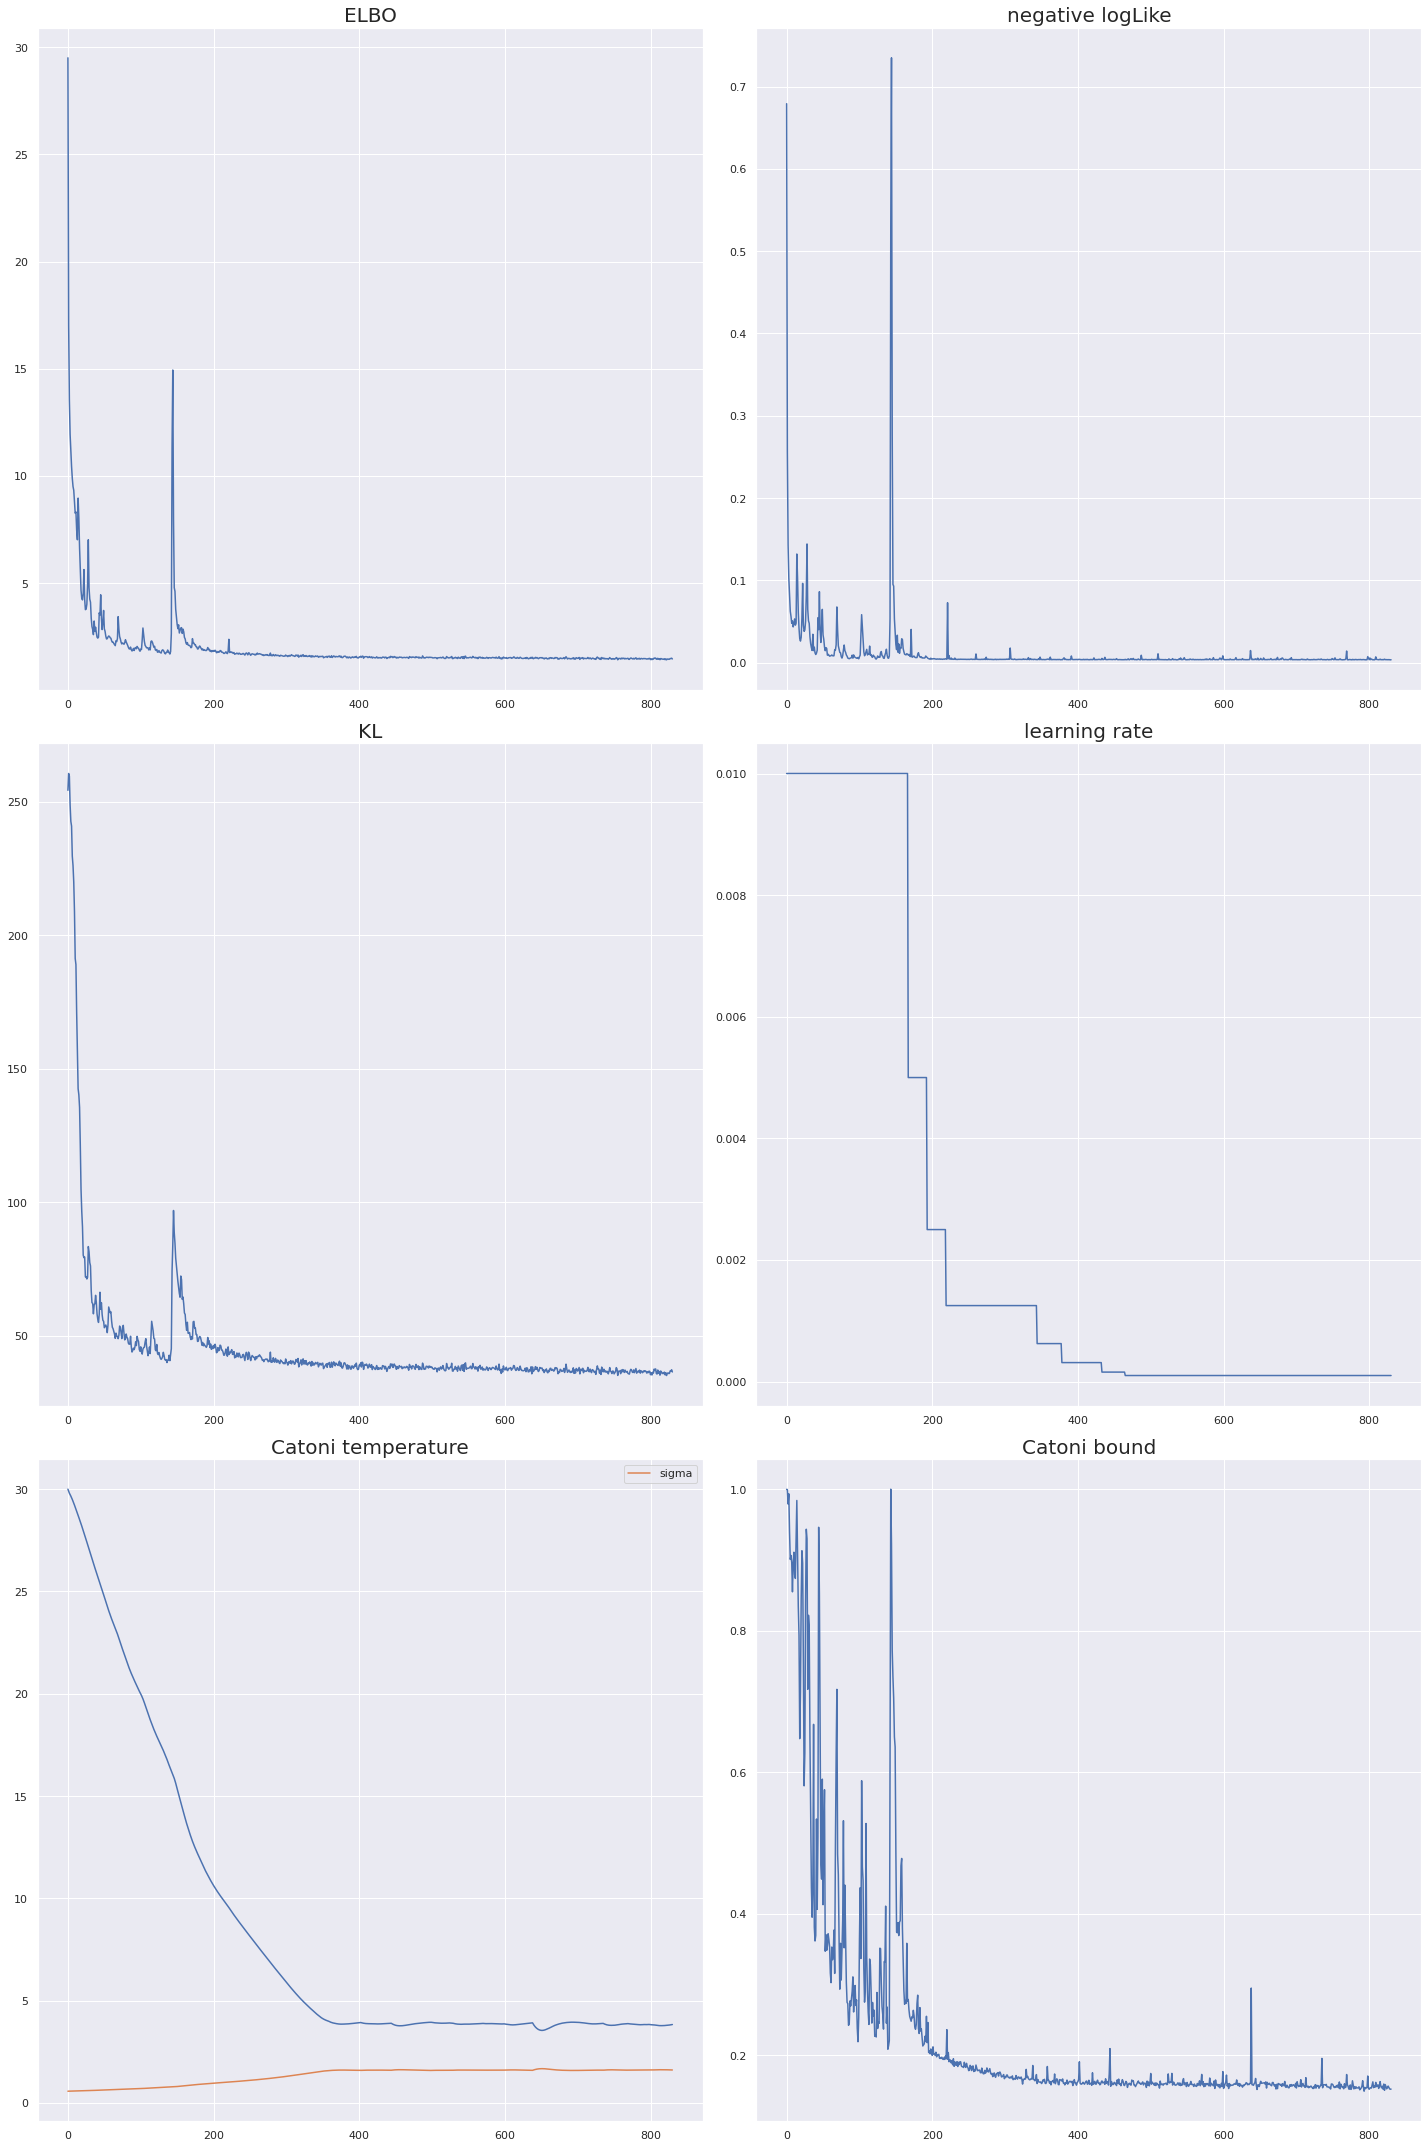

In [118]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs, 'Temp':Ts,'Bound':Bs}
time_line=torch.arange(0,len(training['ELBO']),1)
epoch_line=torch.arange(0,len(training['Temp']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LL_=torch.as_tensor(training['LL'])
LR_=torch.as_tensor(training['LR'])
T_=torch.as_tensor(training['Temp'])
B_=torch.as_tensor(training['Bound'])

fig, ax =plt.subplots(3,2, figsize=(20,30))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
ax[2,0].plot(epoch_line,T_)
ax[2,0].plot(epoch_line,np.sqrt(M/(2*T_)),label='sigma')
ax[2,0].set_title('Catoni temperature', fontsize=20)
ax[2,0].legend()
ax[2,1].plot(epoch_line,B_)
ax[2,1].set_title('Catoni bound', fontsize=20)
fig.tight_layout()

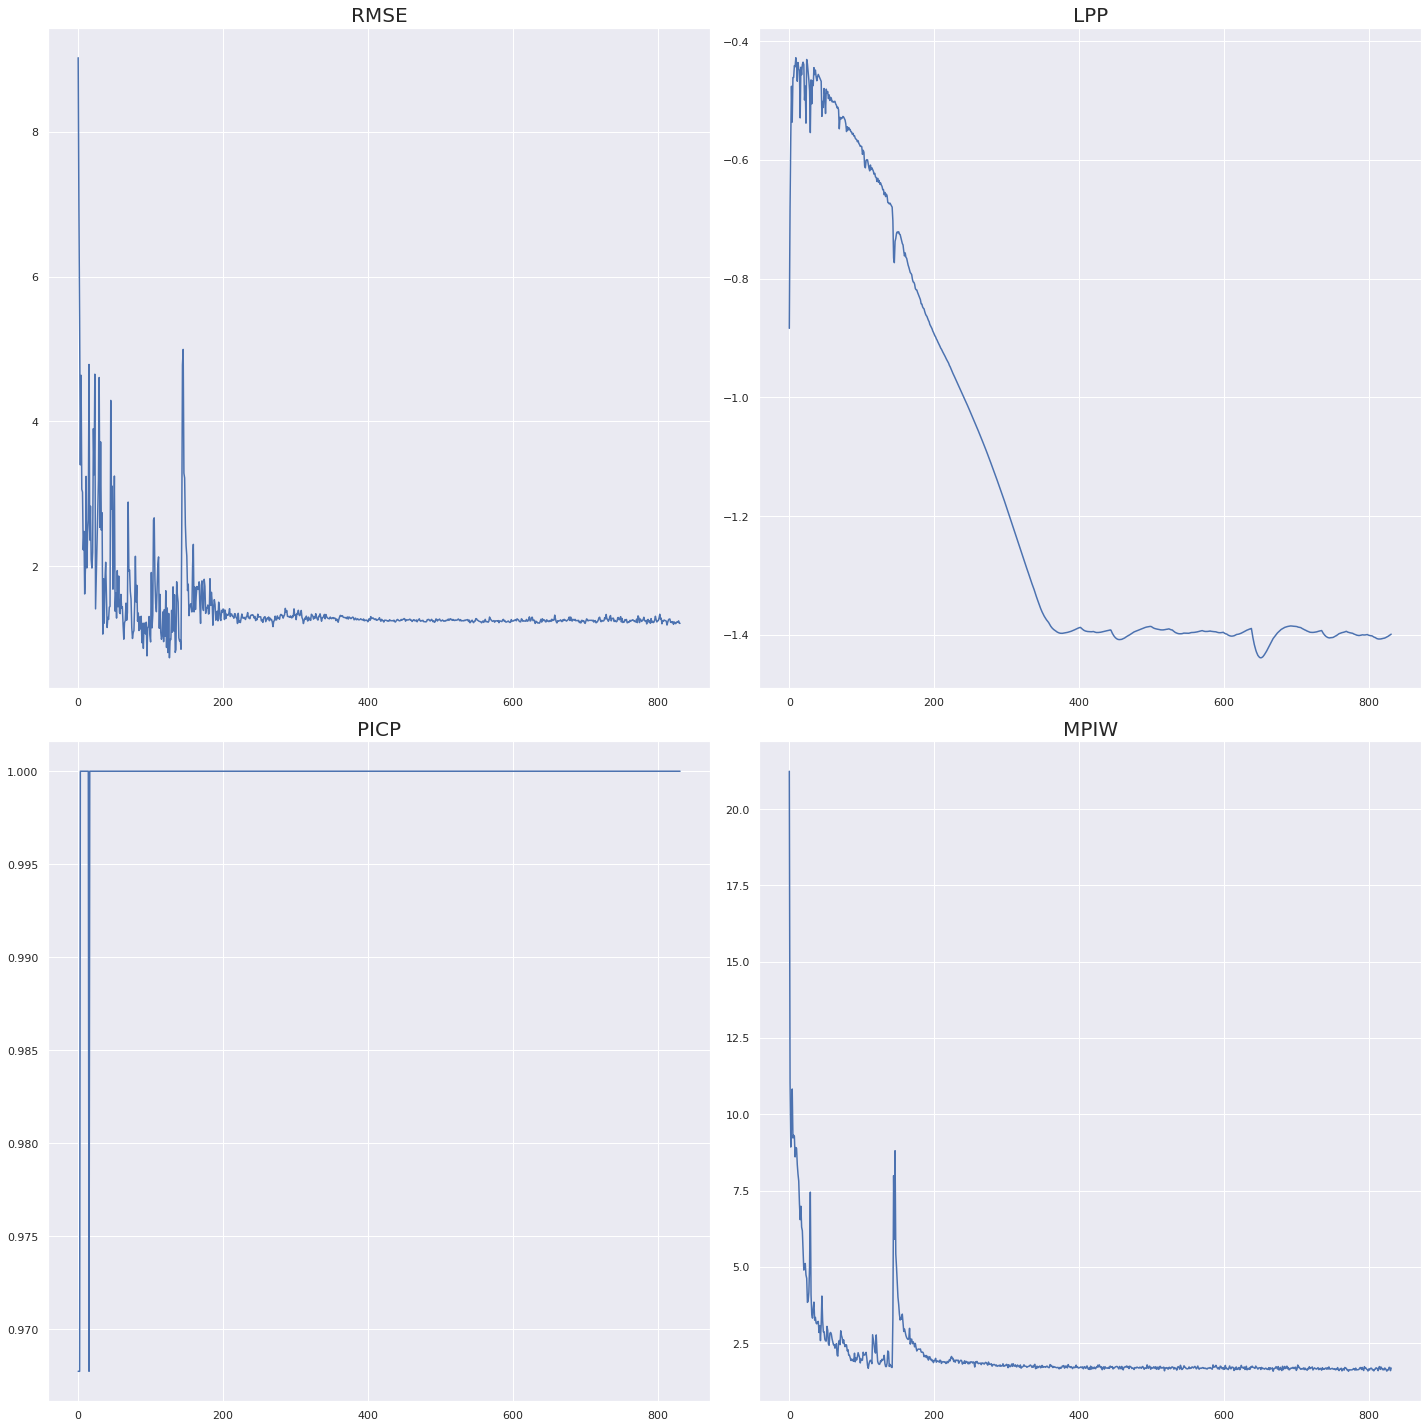

In [119]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(2,2, figsize=(20,20))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
fig.tight_layout()

# posterior predictive diagnostic #

31


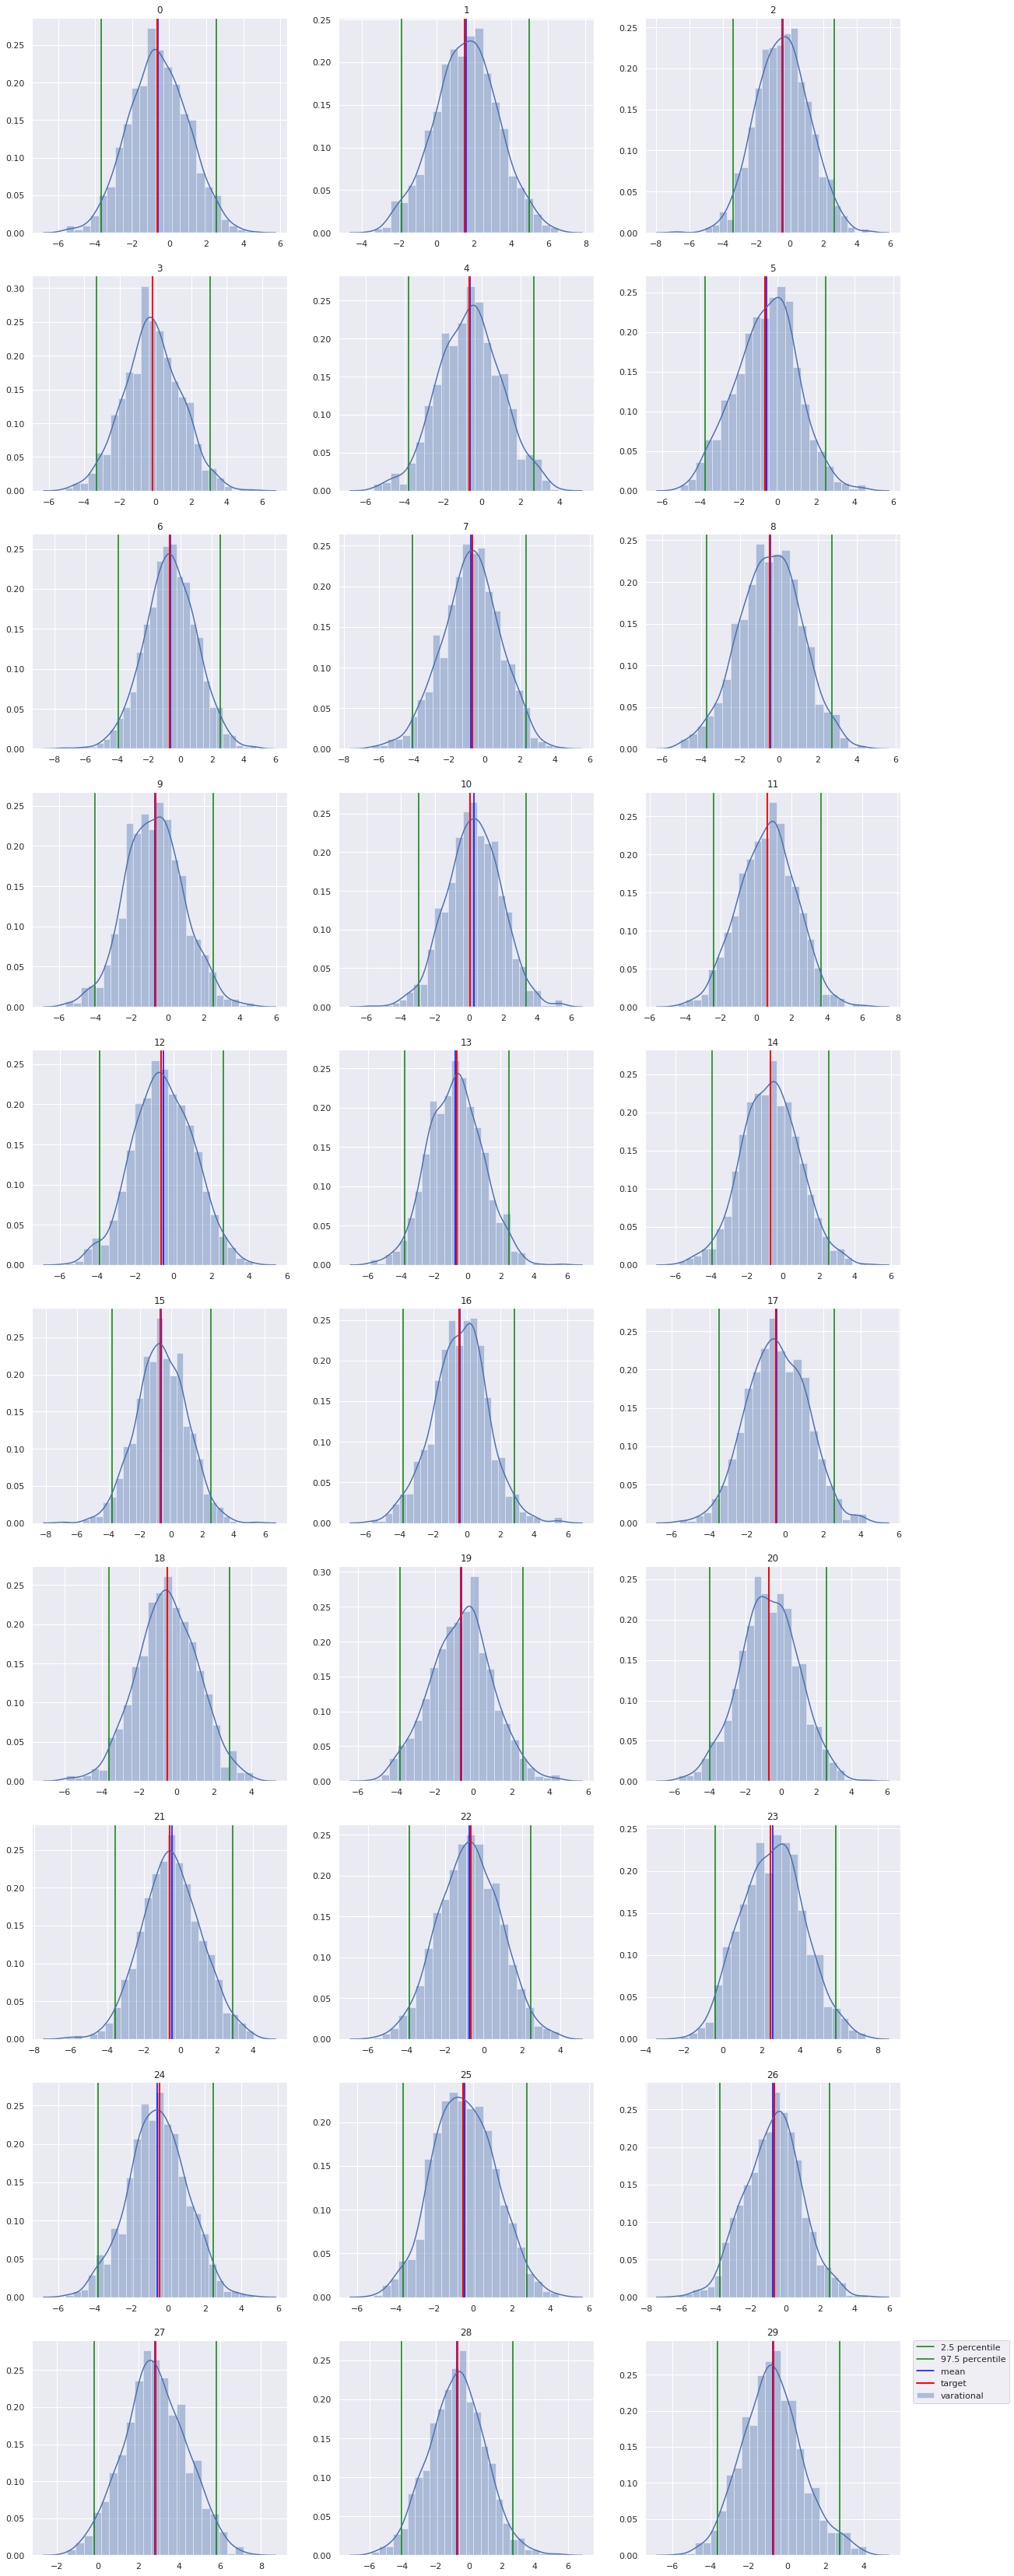

In [120]:
import seaborn as sns
from pylab import *

theta=GeN(1000).detach()
pred_=model(x_train,theta).cpu()
pred=pred_+sigma_noise*torch.randn_like(pred_)
M_ = pred.shape[0]
M_low = int(0.025 * M_)
M_high = int(0.975 * M_)

y_pred_s, _ = pred.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)


sns_plot=sns.set(rc={"figure.figsize": (20, 60)})
rows=10
cols=3
#np.random.seed(42)

for _ in range(1,1+rows*cols):
    i=_-1#np.random.randint(0,y_test.shape[0])
    subplot(rows,cols,_)
    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred.mean(0)[i].cpu(), color='blue', label='mean')
#    ax=sns.distplot(pred_prior[:,i], label='prior')
    line5 =ax=sns.distplot(pred[:,i],label='varational')
    line1=plt.axvline(y_train[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
print(y_test.shape[0])

31


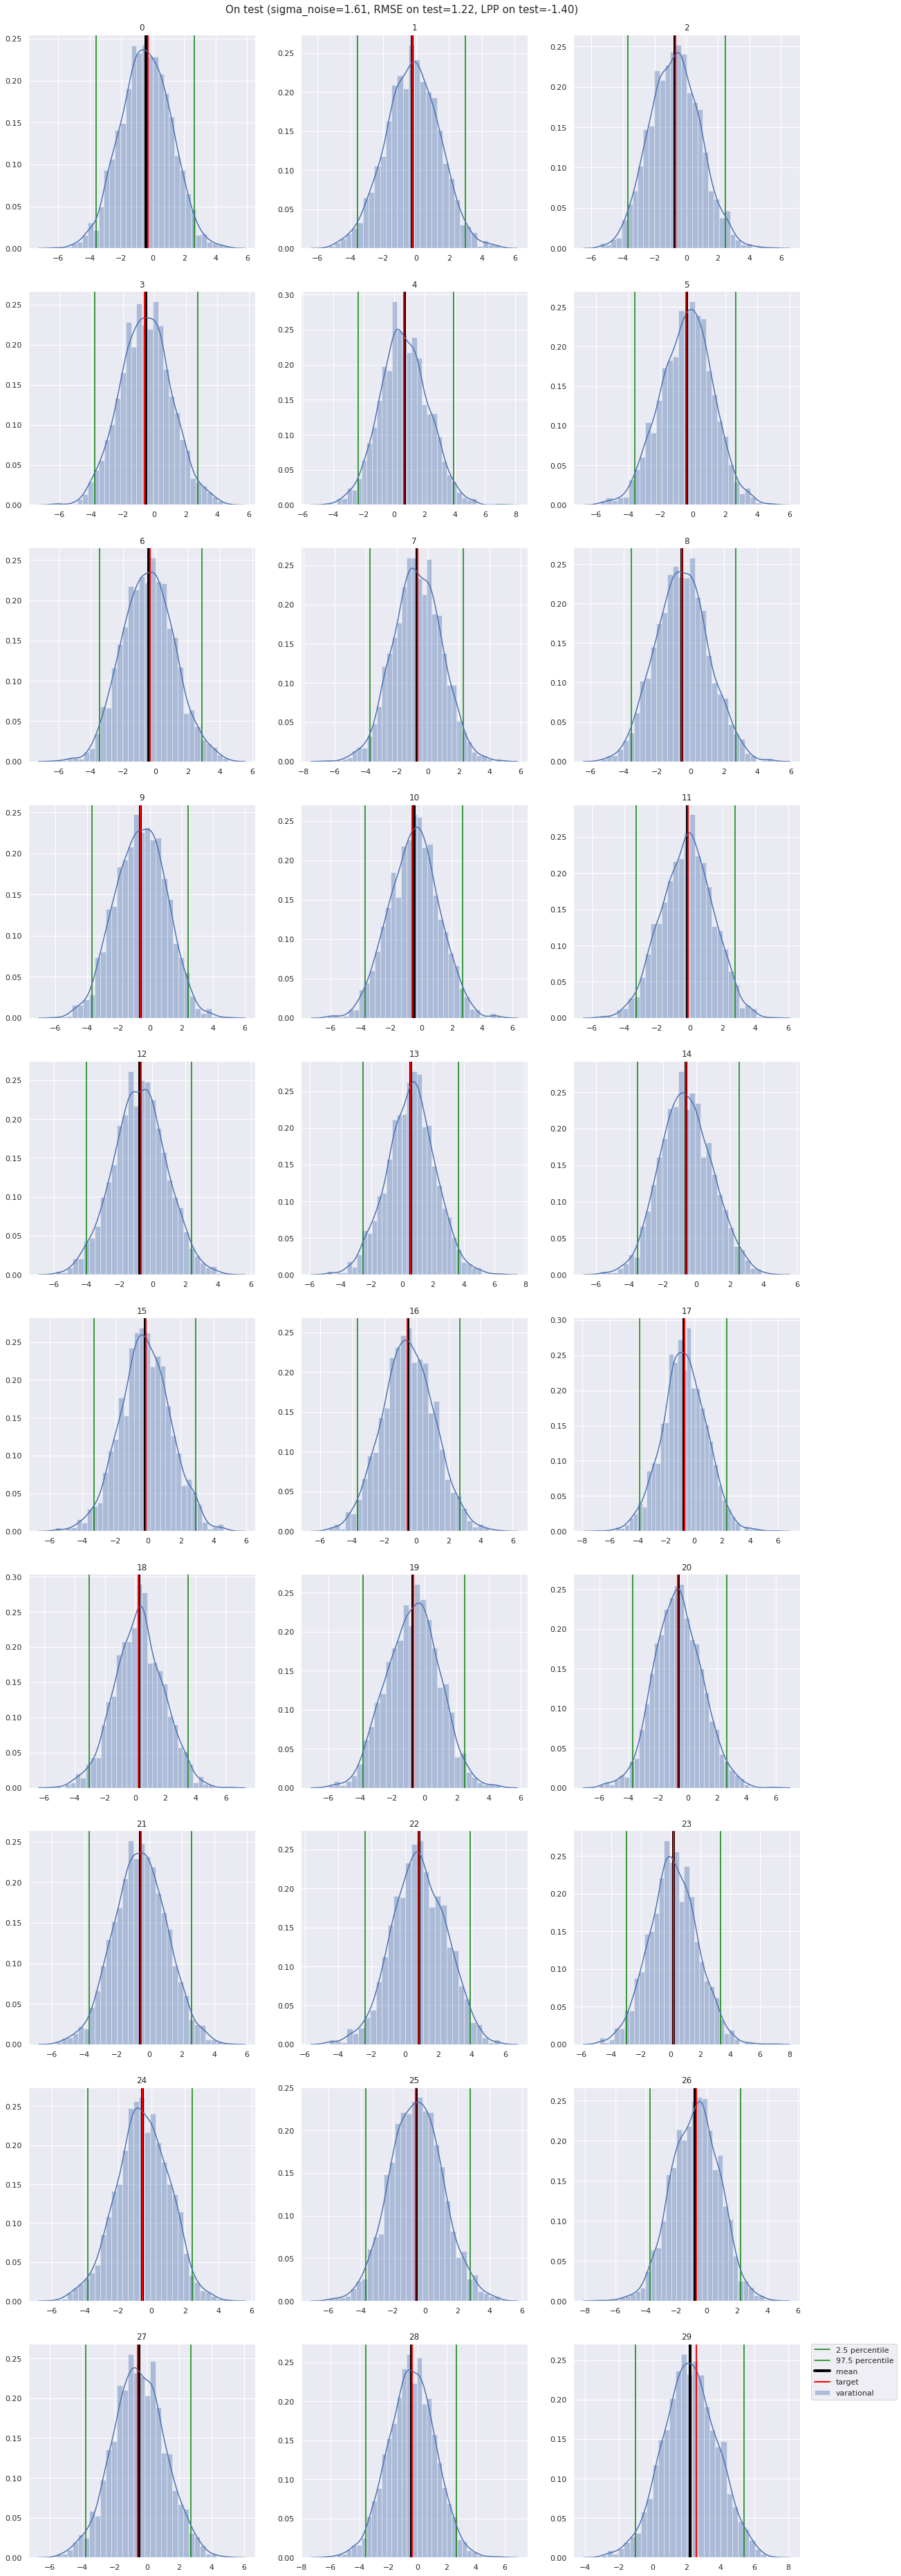

In [121]:
import seaborn as sns
from pylab import *

theta=GeN(2000).detach()
pred_=model(x_test,theta).cpu()
pred=pred_+sigma_noise*torch.randn_like(pred_)
M_ = pred.shape[0]
M_low = int(0.025 * M_)
M_high = int(0.975 * M_)

y_pred_s, _ = pred.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)


sns_plot=sns.set(rc={"figure.figsize": (20, 60)})
rows=10
cols=3
#np.random.seed(42)

for _ in range(1,1+rows*cols):
    i=_-1#np.random.randint(0,y_test.shape[0])
    subplot(rows,cols,_)
    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred.mean(0)[i].cpu(), color='black',lw=4., label='mean')
#    ax=sns.distplot(pred_prior[:,i], label='prior')
    line5 =ax=sns.distplot(pred[:,i],label='varational')
    line1=plt.axvline(y_test[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='On test (sigma_noise={:.2f}, RMSE on test={:.2f}, LPP on test={:.2f})'.format(sigma_noise.item(),metrics['RMSE'][0],metrics['LPP'][0]),fontsize=15)
print(y_test.shape[0])

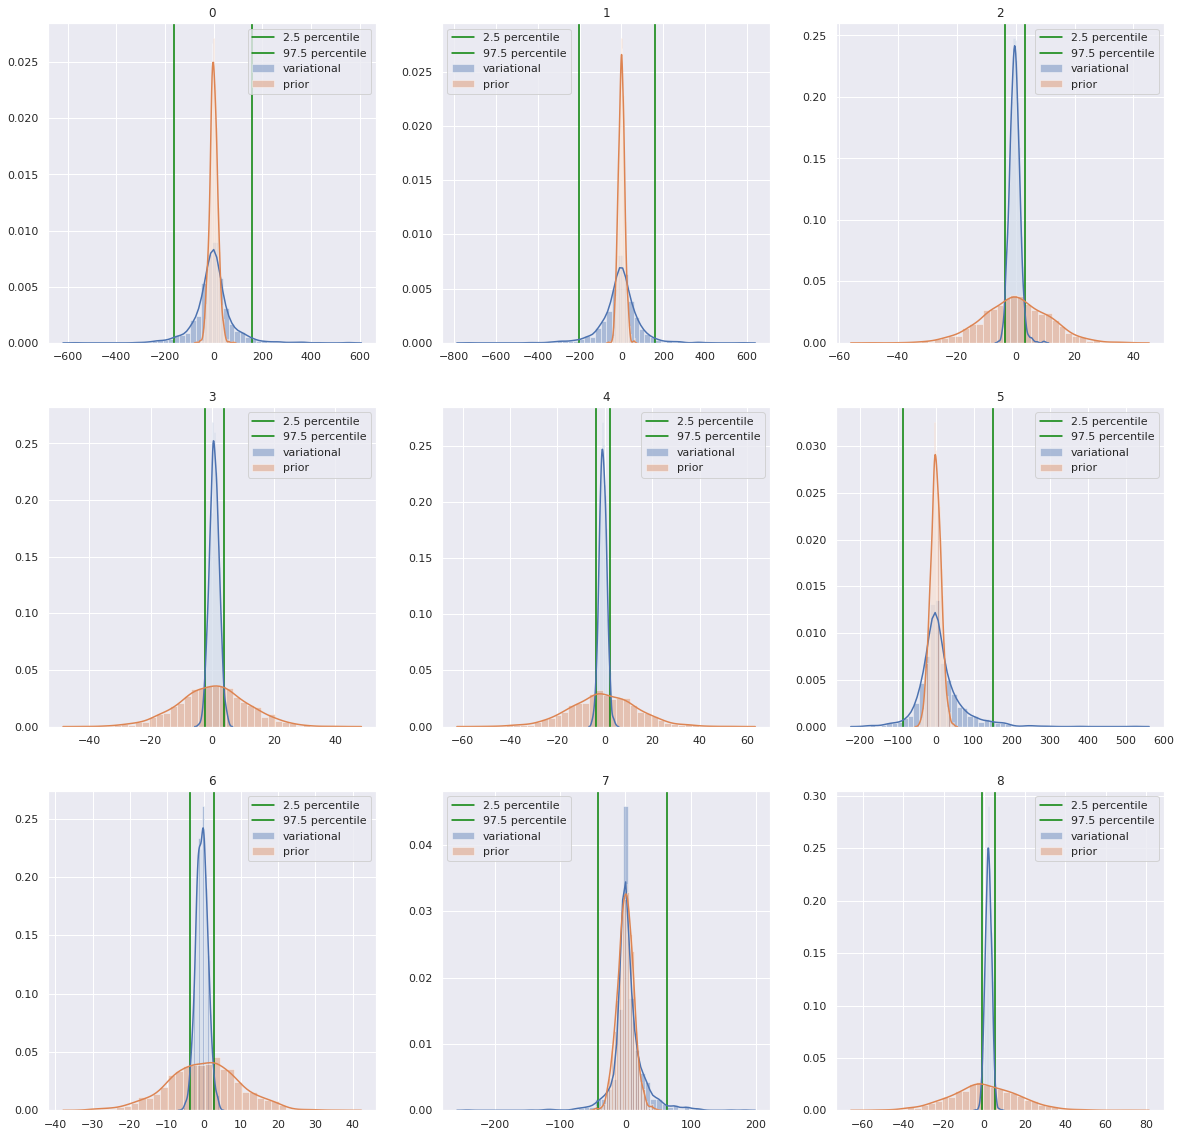

In [32]:
import seaborn as sns
from pylab import *
torch.manual_seed(seed=42) 
theta=GeN(2000).detach()
epsilon=0.1
n_ood=9
b = x_train.max(0, keepdim=True)[0]+epsilon
a = x_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (b-a) + a  
pred_=model(X_ood,theta).cpu()
pred=pred_+sigma_noise*torch.randn_like(pred_)

theta_prior=prior(2000)
pred_prior=model(X_ood,theta_prior).cpu()
M_ = pred.shape[0]
M_low = int(0.025 * M_)
M_high = int(0.975 * M_)

y_pred_s, _ = pred.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)

sns.set(rc={"figure.figsize": (20, 20)})
rows=3
for i in range(0,rows**2):
    subplot(rows,rows,i+1)
    plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    plt.title(str(i))
    ax=sns.distplot(pred[:,i], label='variational')
    ax=sns.distplot(pred_prior[:,i], label='prior')
    plt.legend()


# distance to HMC #

In [48]:
from Metrics import FunSW, FunKL
device='cuda:0'

def projection(theta0,theta1, n_input_samples):
    #batch sample OOD   
    n_ood=n_input_samples
    epsilon=0.1
    x_train_=x_train.to(device)
    M = x_train_.max(0, keepdim=True)[0]+epsilon
    m = x_train_.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=X_ood

    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj


def _FunKL(s,t,projection,device):
    k=1
    FKL=FunKL(s,t,projection=projection,device=device,k=k)
    while torch.isinf(FKL):
        k+=1
        FKL=FunKL(s,t,projection=projection,device=device,k=k)
    return FKL


In [89]:
models_HMC = torch.load('Results/HMC_models.pt')
t=models_HMC[dataset].to(device)
s=GeN(t.shape[0]).detach().to(device)
kl_to=_FunKL(s,t,projection,device)
kl_from=_FunKL(t,s,projection,device)
print('KL(-,HMC): '+str(kl_to.item()))
print('KL(HMC,-): '+str(kl_from.item()))

KL(-,HMC): 28.79901123046875
KL(HMC,-): 114.59158325195312


# grid search #


In [64]:
def meanlogKNNdistance(sample,k):
    distances= torch.cdist(sample, sample, p=2)
    kNN = torch.topk(distances, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf
    return kNN.log().mean()

def kl(x_data, GeN,beta):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device, beta=beta)
    return K

def run(beta,alpha):
    def ELBO(x_data, y_data, GeN, beta=beta):
        #alpha=.5#(len(x_data)/size_data)
        Average_LogLikelihood=loss(x_data, y_data, GeN)
        the_KL=kl(x_data, GeN, beta)
        the_ELBO= - Average_LogLikelihood+ alpha*the_KL
        return the_ELBO, the_KL, Average_LogLikelihood 
    GeN = BigGenerator(lat_dim,param_count,device).to(device)
    optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)
    Run=IVI(train_loader, ELBO, optimizer)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=False, min_lr=min_lr)
    
    for t in range(n_epochs):
        scores=Run.run(GeN)
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break

    theta=GeN(2000).detach()
    metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu', std=False)
    meanNNs=[]
    for (x,y) in train_loader:
        sample=GeN(n_samples_KL)
        pred,_=projection(sample,sample,x)
        meanNNs.append(meanlogKNNdistance(pred,k=1).item())
    metrics.update({'meanNN':np.mean(meanNNs),'beta':beta, 'alpha':alpha})
    print(metrics)
    return metrics 


In [99]:
betas=torch.linspace(0.1,1.1,10).numpy()
alphas=torch.linspace(0.1, 1.0, 5).numpy()
gs_results=[]
for i in trange(len(betas)):
    for j in range(len(alphas)):
        print(betas[i],alphas[j])
        gs_results.append(run(betas[i],alphas[j]))

    



  0%|          | 0/10 [00:00<?, ?it/s]

0.1 0.1
{'RMSE': 1.6707737445831299, 'LPP': -1.2595449466976718, 'PICP': 0.9677419066429138, 'MPIW': 3.872786283493042, 'meanNN': 1.072901290655136, 'beta': 0.1, 'alpha': 0.1}
0.1 0.325
{'RMSE': 3.3594939708709717, 'LPP': -1.2739490859280824, 'PICP': 0.9032257795333862, 'MPIW': 9.86617660522461, 'meanNN': 1.1398974299430846, 'beta': 0.1, 'alpha': 0.325}
0.1 0.55
{'RMSE': 4.281418800354004, 'LPP': -1.2952319770789547, 'PICP': 0.9677419066429138, 'MPIW': 17.732343673706055, 'meanNN': 1.154675579071045, 'beta': 0.1, 'alpha': 0.55}
0.1 0.775
{'RMSE': 5.395841598510742, 'LPP': -1.3165567507379168, 'PICP': 0.9354838728904724, 'MPIW': 21.840805053710938, 'meanNN': 1.1438507318496705, 'beta': 0.1, 'alpha': 0.775}
0.1 1.0


 10%|█         | 1/10 [01:48<16:20, 108.98s/it]

{'RMSE': 5.778838634490967, 'LPP': -1.3341778085327765, 'PICP': 0.9677419066429138, 'MPIW': 26.77571678161621, 'meanNN': 1.2481667280197144, 'beta': 0.1, 'alpha': 1.0}
0.21111111 0.1
{'RMSE': 1.5666085481643677, 'LPP': -1.2594374031052111, 'PICP': 0.9032257795333862, 'MPIW': 4.105088710784912, 'meanNN': 1.7224966168403626, 'beta': 0.21111111, 'alpha': 0.1}
0.21111111 0.325
{'RMSE': 3.3987133502960205, 'LPP': -1.2783245274882487, 'PICP': 0.9354838728904724, 'MPIW': 12.734519004821777, 'meanNN': 1.7107221722602843, 'beta': 0.21111111, 'alpha': 0.325}
0.21111111 0.55
{'RMSE': 4.135095119476318, 'LPP': -1.302308531927083, 'PICP': 0.9677419066429138, 'MPIW': 20.98815155029297, 'meanNN': 1.7139638900756835, 'beta': 0.21111111, 'alpha': 0.55}
0.21111111 0.775
{'RMSE': 4.928505897521973, 'LPP': -1.329462024505334, 'PICP': 0.9677419066429138, 'MPIW': 27.48482322692871, 'meanNN': 1.734901487827301, 'beta': 0.21111111, 'alpha': 0.775}
0.21111111 1.0


 20%|██        | 2/10 [04:03<15:32, 116.61s/it]

{'RMSE': 5.768859386444092, 'LPP': -1.354160347559268, 'PICP': 0.9677419066429138, 'MPIW': 32.30874252319336, 'meanNN': 1.7442123413085937, 'beta': 0.21111111, 'alpha': 1.0}
0.32222223 0.1
{'RMSE': 1.4275168180465698, 'LPP': -1.2587940530285013, 'PICP': 0.9032257795333862, 'MPIW': 3.633514404296875, 'meanNN': 2.0583067297935487, 'beta': 0.32222223, 'alpha': 0.1}
0.32222223 0.325
{'RMSE': 2.6834871768951416, 'LPP': -1.2725145518383092, 'PICP': 0.9032257795333862, 'MPIW': 11.667741775512695, 'meanNN': 2.0565129637718202, 'beta': 0.32222223, 'alpha': 0.325}
0.32222223 0.55
{'RMSE': 3.600895404815674, 'LPP': -1.296819283899279, 'PICP': 1.0, 'MPIW': 20.96227264404297, 'meanNN': 2.099967122077942, 'beta': 0.32222223, 'alpha': 0.55}
0.32222223 0.775
{'RMSE': 4.946075439453125, 'LPP': -1.3366436760554292, 'PICP': 1.0, 'MPIW': 30.204423904418945, 'meanNN': 2.046002471446991, 'beta': 0.32222223, 'alpha': 0.775}
0.32222223 1.0


 30%|███       | 3/10 [07:20<16:24, 140.71s/it]

{'RMSE': 5.184062480926514, 'LPP': -1.3693979100551277, 'PICP': 1.0, 'MPIW': 37.526466369628906, 'meanNN': 2.0566017627716064, 'beta': 0.32222223, 'alpha': 1.0}
0.43333334 0.1
{'RMSE': 1.4399330615997314, 'LPP': -1.258763152282785, 'PICP': 0.8709677457809448, 'MPIW': 3.4983320236206055, 'meanNN': 2.315600061416626, 'beta': 0.43333334, 'alpha': 0.1}
0.43333334 0.325
{'RMSE': 2.662724018096924, 'LPP': -1.2714457800123666, 'PICP': 0.9354838728904724, 'MPIW': 11.121879577636719, 'meanNN': 2.31836519241333, 'beta': 0.43333334, 'alpha': 0.325}
0.43333334 0.55
{'RMSE': 3.3849544525146484, 'LPP': -1.2915695855511846, 'PICP': 1.0, 'MPIW': 19.43172836303711, 'meanNN': 2.3047652006149293, 'beta': 0.43333334, 'alpha': 0.55}
0.43333334 0.775
{'RMSE': 4.311165809631348, 'LPP': -1.3355237305593641, 'PICP': 1.0, 'MPIW': 31.706947326660156, 'meanNN': 2.320189619064331, 'beta': 0.43333334, 'alpha': 0.775}
0.43333334 1.0


 40%|████      | 4/10 [11:09<16:44, 167.34s/it]

{'RMSE': 4.82712459564209, 'LPP': -1.3665875110950305, 'PICP': 1.0, 'MPIW': 39.21125793457031, 'meanNN': 2.2751274585723875, 'beta': 0.43333334, 'alpha': 1.0}
0.54444444 0.1
{'RMSE': 1.3818614482879639, 'LPP': -1.2584817926430438, 'PICP': 0.8064516186714172, 'MPIW': 2.856955051422119, 'meanNN': 2.596231746673584, 'beta': 0.54444444, 'alpha': 0.1}
0.54444444 0.325
{'RMSE': 2.2545440196990967, 'LPP': -1.2679602590924512, 'PICP': 0.9677419066429138, 'MPIW': 9.84122371673584, 'meanNN': 2.565013027191162, 'beta': 0.54444444, 'alpha': 0.325}
0.54444444 0.55
{'RMSE': 3.103696823120117, 'LPP': -1.2862327320905051, 'PICP': 1.0, 'MPIW': 17.936487197875977, 'meanNN': 2.5513420581817625, 'beta': 0.54444444, 'alpha': 0.55}
0.54444444 0.775
{'RMSE': 3.779327869415283, 'LPP': -1.316373809290182, 'PICP': 1.0, 'MPIW': 27.62285804748535, 'meanNN': 2.539513945579529, 'beta': 0.54444444, 'alpha': 0.775}
0.54444444 1.0


 50%|█████     | 5/10 [15:21<16:03, 192.60s/it]

{'RMSE': 4.332343101501465, 'LPP': -1.35915336615056, 'PICP': 1.0, 'MPIW': 38.36735534667969, 'meanNN': 2.538687539100647, 'beta': 0.54444444, 'alpha': 1.0}
0.6555556 0.1
{'RMSE': 1.3199726343154907, 'LPP': -1.258175901969707, 'PICP': 0.9354838728904724, 'MPIW': 2.7951443195343018, 'meanNN': 2.8179200649261475, 'beta': 0.6555556, 'alpha': 0.1}
0.6555556 0.325
{'RMSE': 2.229140281677246, 'LPP': -1.2653350540455321, 'PICP': 0.9354838728904724, 'MPIW': 7.296849250793457, 'meanNN': 2.860593247413635, 'beta': 0.6555556, 'alpha': 0.325}
0.6555556 0.55
{'RMSE': 2.6669178009033203, 'LPP': -1.2755385452683208, 'PICP': 0.9677419066429138, 'MPIW': 13.364824295043945, 'meanNN': 2.8416894912719726, 'beta': 0.6555556, 'alpha': 0.55}
0.6555556 0.775
{'RMSE': 3.076242446899414, 'LPP': -1.3034800577489773, 'PICP': 1.0, 'MPIW': 24.76103401184082, 'meanNN': 2.7466014623641968, 'beta': 0.6555556, 'alpha': 0.775}
0.6555556 1.0


 60%|██████    | 6/10 [20:45<15:28, 232.06s/it]

{'RMSE': 3.864717721939087, 'LPP': -1.3303809468057122, 'PICP': 1.0, 'MPIW': 31.585115432739258, 'meanNN': 2.7925063133239747, 'beta': 0.6555556, 'alpha': 1.0}
0.7666667 0.1
{'RMSE': 1.270805835723877, 'LPP': -1.2578939771469975, 'PICP': 0.8709677457809448, 'MPIW': 2.341050148010254, 'meanNN': 3.0685379028320314, 'beta': 0.7666667, 'alpha': 0.1}
0.7666667 0.325
{'RMSE': 1.8692047595977783, 'LPP': -1.2627927629062423, 'PICP': 0.9354838728904724, 'MPIW': 6.018332481384277, 'meanNN': 3.08214795589447, 'beta': 0.7666667, 'alpha': 0.325}
0.7666667 0.55
{'RMSE': 2.340862989425659, 'LPP': -1.2726921455055076, 'PICP': 0.9354838728904724, 'MPIW': 12.203717231750488, 'meanNN': 3.045382285118103, 'beta': 0.7666667, 'alpha': 0.55}
0.7666667 0.775
{'RMSE': 2.8054003715515137, 'LPP': -1.2852942023466405, 'PICP': 1.0, 'MPIW': 17.738853454589844, 'meanNN': 3.0542694091796876, 'beta': 0.7666667, 'alpha': 0.775}
0.7666667 1.0


 70%|███████   | 7/10 [26:19<13:08, 262.70s/it]

{'RMSE': 3.166128635406494, 'LPP': -1.3022601279921049, 'PICP': 1.0, 'MPIW': 24.287778854370117, 'meanNN': 3.0504446506500242, 'beta': 0.7666667, 'alpha': 1.0}
0.8777778 0.1
{'RMSE': 1.077911376953125, 'LPP': -1.2570940262703403, 'PICP': 0.8709677457809448, 'MPIW': 1.6241093873977661, 'meanNN': 3.4227551460266112, 'beta': 0.8777778, 'alpha': 0.1}
0.8777778 0.325
{'RMSE': 1.3518261909484863, 'LPP': -1.260506804747095, 'PICP': 1.0, 'MPIW': 5.428941249847412, 'meanNN': 3.3734017848968505, 'beta': 0.8777778, 'alpha': 0.325}
0.8777778 0.55
{'RMSE': 1.7585558891296387, 'LPP': -1.2642802710511396, 'PICP': 0.9677419066429138, 'MPIW': 7.460154056549072, 'meanNN': 3.4172458171844484, 'beta': 0.8777778, 'alpha': 0.55}
0.8777778 0.775
{'RMSE': 2.3565406799316406, 'LPP': -1.2740371486055917, 'PICP': 1.0, 'MPIW': 12.757219314575195, 'meanNN': 3.3863399267196654, 'beta': 0.8777778, 'alpha': 0.775}
0.8777778 1.0


 80%|████████  | 8/10 [32:43<09:58, 299.01s/it]

{'RMSE': 2.4544179439544678, 'LPP': -1.2826302845193072, 'PICP': 1.0, 'MPIW': 17.087427139282227, 'meanNN': 3.4019762754440306, 'beta': 0.8777778, 'alpha': 1.0}
0.9888889 0.1
{'RMSE': 1.129467487335205, 'LPP': -1.257130865287498, 'PICP': 0.6774193644523621, 'MPIW': 1.5683817863464355, 'meanNN': 3.7793304681777955, 'beta': 0.9888889, 'alpha': 0.1}
0.9888889 0.325
{'RMSE': 1.3826707601547241, 'LPP': -1.258490179054598, 'PICP': 0.8387096524238586, 'MPIW': 2.168349027633667, 'meanNN': 4.021446323394775, 'beta': 0.9888889, 'alpha': 0.325}
0.9888889 0.55
{'RMSE': 1.3274152278900146, 'LPP': -1.259107664178907, 'PICP': 0.9354838728904724, 'MPIW': 3.554807186126709, 'meanNN': 4.01607882976532, 'beta': 0.9888889, 'alpha': 0.55}
0.9888889 0.775
{'RMSE': 1.8207076787948608, 'LPP': -1.2627797789571138, 'PICP': 0.9354838728904724, 'MPIW': 5.399949073791504, 'meanNN': 3.961567258834839, 'beta': 0.9888889, 'alpha': 0.775}
0.9888889 1.0


 90%|█████████ | 9/10 [38:42<05:17, 317.06s/it]

{'RMSE': 1.6856507062911987, 'LPP': -1.263755505745274, 'PICP': 1.0, 'MPIW': 6.419355869293213, 'meanNN': 4.030099964141845, 'beta': 0.9888889, 'alpha': 1.0}
1.1 0.1
{'RMSE': 1.4022992849349976, 'LPP': -1.258188107691122, 'PICP': 0.7419354915618896, 'MPIW': 2.7663893699645996, 'meanNN': 8.011188507080078, 'beta': 1.1, 'alpha': 0.1}
1.1 0.325
{'RMSE': 2.6004679203033447, 'LPP': -1.2644078777912173, 'PICP': 0.5161290168762207, 'MPIW': 4.135901927947998, 'meanNN': 8.81450891494751, 'beta': 1.1, 'alpha': 0.325}
1.1 0.55
{'RMSE': 2.459296703338623, 'LPP': -1.2680654023444142, 'PICP': 0.9677419066429138, 'MPIW': 8.320428848266602, 'meanNN': 6.068145799636841, 'beta': 1.1, 'alpha': 0.55}
1.1 0.775
{'RMSE': 2.30023193359375, 'LPP': -1.2623369123143093, 'PICP': 0.5806451439857483, 'MPIW': 3.8936309814453125, 'meanNN': 8.875388050079346, 'beta': 1.1, 'alpha': 0.775}
1.1 1.0


100%|██████████| 10/10 [43:03<00:00, 258.30s/it]

{'RMSE': 10.866762161254883, 'LPP': -1.381717176365887, 'PICP': 0.06451612710952759, 'MPIW': 4.403170585632324, 'meanNN': 6.661285638809204, 'beta': 1.1, 'alpha': 1.0}


In [100]:
import pandas as pd
results=pd.DataFrame(gs_results)

<Figure size 720x720 with 0 Axes>

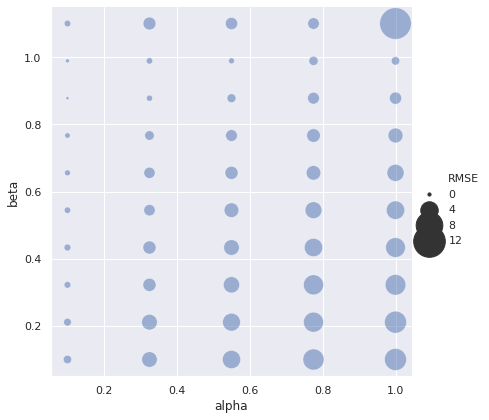

In [109]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.relplot(x="alpha", y="beta", size="RMSE",
            sizes=(10, 1000), alpha=.5, palette="muted",
            height=6, data=results)
#results['RMSE']

0    1.535557
1    1.674343
2    1.478293
3    1.335660
4    1.630986
5    1.178999
6    1.601035
7    1.563687
8    1.578547
9    1.604341
Name: RMSE, dtype: float64


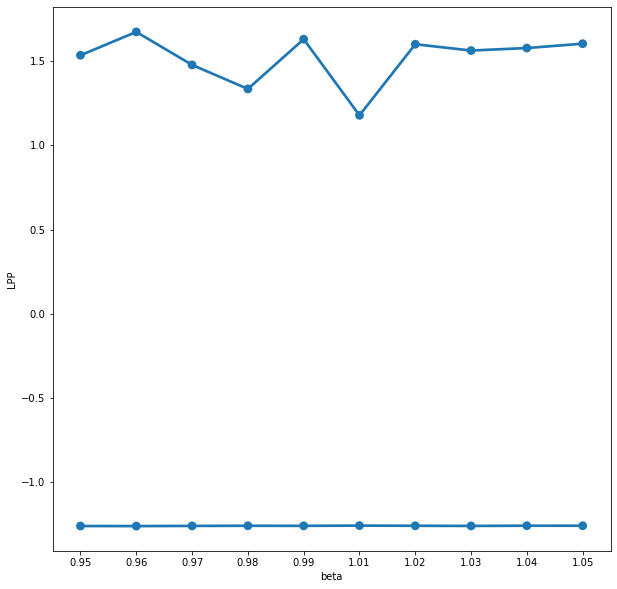

In [43]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax=sns.pointplot('beta','RMSE', data=results,ci=None)
ax=sns.pointplot('beta','LPP', data=results,ci=None)
xlabels = np.round(betas,2)
ax.set_xticklabels(xlabels)
print(results['RMSE'])

2.945533347129822


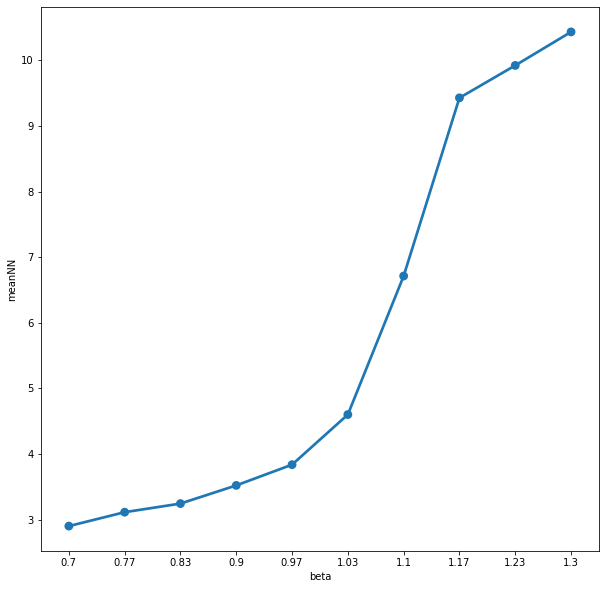

In [24]:
plt.figure(figsize=(10,10))

ax=sns.pointplot('beta','meanNN', data=results,ci=None)
xlabels = np.round(betas,2)
ax.set_xticklabels(xlabels)
meanNNs=[]

for (x,y) in train_loader:
    sample=prior(n_samples_KL)
    prior_pred,_=projection(sample,sample,x)
    meanNNs.append(meanlogKNNdistance(prior_pred,k=1).item())
print(np.mean(meanNNs))

In [35]:
from Inference.PointEstimate import AdamGradientDescent

def loglikelihood(theta):
    y_pred=model(x_train,theta)
    return NormalLogLikelihood(y_pred, y_train, sigma_noise).sum(dim=1)

optimizer = AdamGradientDescent(loglikelihood, 10000, .01, .00000001, 50, .5, device, True)

theta0 = torch.empty((1, param_count), device=device).normal_(0., std=1.)
best_theta, best_score, score = optimizer.run(theta0)

Epoch [1/10000], Loss: 14682.638671875, Learning Rate: 0.01
Epoch [2/10000], Loss: 12998.166015625, Learning Rate: 0.01
Epoch [3/10000], Loss: 11442.849609375, Learning Rate: 0.01
Epoch [4/10000], Loss: 10021.4697265625, Learning Rate: 0.01
Epoch [5/10000], Loss: 8725.4296875, Learning Rate: 0.01
Epoch [6/10000], Loss: 7553.14599609375, Learning Rate: 0.01
Epoch [7/10000], Loss: 6500.3671875, Learning Rate: 0.01
Epoch [8/10000], Loss: 5565.88525390625, Learning Rate: 0.01
Epoch [9/10000], Loss: 4744.56640625, Learning Rate: 0.01
Epoch [10/10000], Loss: 4030.98291015625, Learning Rate: 0.01
Epoch [11/10000], Loss: 3417.4541015625, Learning Rate: 0.01
Epoch [12/10000], Loss: 2898.18115234375, Learning Rate: 0.01
Epoch [13/10000], Loss: 2465.547607421875, Learning Rate: 0.01
Epoch [14/10000], Loss: 2112.595458984375, Learning Rate: 0.01
Epoch [15/10000], Loss: 1831.05322265625, Learning Rate: 0.01
Epoch [16/10000], Loss: 1612.8822021484375, Learning Rate: 0.01
Epoch [17/10000], Loss: 1449

Epoch [252/10000], Loss: 358.4837646484375, Learning Rate: 0.01
Epoch [253/10000], Loss: 358.3995361328125, Learning Rate: 0.01
Epoch [254/10000], Loss: 358.3165283203125, Learning Rate: 0.01
Epoch [255/10000], Loss: 358.2347717285156, Learning Rate: 0.01
Epoch [256/10000], Loss: 358.15386962890625, Learning Rate: 0.01
Epoch [257/10000], Loss: 358.0728759765625, Learning Rate: 0.01
Epoch [258/10000], Loss: 357.99176025390625, Learning Rate: 0.01
Epoch [259/10000], Loss: 357.91162109375, Learning Rate: 0.01
Epoch [260/10000], Loss: 357.83282470703125, Learning Rate: 0.01
Epoch [261/10000], Loss: 357.75518798828125, Learning Rate: 0.01
Epoch [262/10000], Loss: 357.67864990234375, Learning Rate: 0.01
Epoch [263/10000], Loss: 357.603271484375, Learning Rate: 0.01
Epoch [264/10000], Loss: 357.52618408203125, Learning Rate: 0.01
Epoch [265/10000], Loss: 357.4457702636719, Learning Rate: 0.01
Epoch [266/10000], Loss: 357.365966796875, Learning Rate: 0.01
Epoch [267/10000], Loss: 357.286560058

Epoch [505/10000], Loss: 350.21563720703125, Learning Rate: 0.01
Epoch [506/10000], Loss: 350.2057800292969, Learning Rate: 0.01
Epoch [507/10000], Loss: 350.1960754394531, Learning Rate: 0.01
Epoch [508/10000], Loss: 350.1865234375, Learning Rate: 0.01
Epoch [509/10000], Loss: 350.17694091796875, Learning Rate: 0.01
Epoch [510/10000], Loss: 350.1676025390625, Learning Rate: 0.01
Epoch [511/10000], Loss: 350.1583251953125, Learning Rate: 0.01
Epoch [512/10000], Loss: 350.1491394042969, Learning Rate: 0.01
Epoch [513/10000], Loss: 350.1400146484375, Learning Rate: 0.01
Epoch [514/10000], Loss: 350.13104248046875, Learning Rate: 0.01
Epoch [515/10000], Loss: 350.1221923828125, Learning Rate: 0.01
Epoch [516/10000], Loss: 350.11328125, Learning Rate: 0.01
Epoch [517/10000], Loss: 350.10430908203125, Learning Rate: 0.01
Epoch [518/10000], Loss: 350.09539794921875, Learning Rate: 0.01
Epoch [519/10000], Loss: 350.0865478515625, Learning Rate: 0.01
Epoch [520/10000], Loss: 350.0777587890625,

Epoch [758/10000], Loss: 348.9371643066406, Learning Rate: 0.01
Epoch [759/10000], Loss: 348.9345703125, Learning Rate: 0.01
Epoch [760/10000], Loss: 348.9319763183594, Learning Rate: 0.01
Epoch [761/10000], Loss: 348.92938232421875, Learning Rate: 0.01
Epoch [762/10000], Loss: 348.9267883300781, Learning Rate: 0.01
Epoch [763/10000], Loss: 348.9242248535156, Learning Rate: 0.01
Epoch [764/10000], Loss: 348.92169189453125, Learning Rate: 0.01
Epoch [765/10000], Loss: 348.91912841796875, Learning Rate: 0.01
Epoch [766/10000], Loss: 348.9166564941406, Learning Rate: 0.01
Epoch [767/10000], Loss: 348.9141540527344, Learning Rate: 0.01
Epoch [768/10000], Loss: 348.9116516113281, Learning Rate: 0.01
Epoch [769/10000], Loss: 348.9091796875, Learning Rate: 0.01
Epoch [770/10000], Loss: 348.90673828125, Learning Rate: 0.01
Epoch [771/10000], Loss: 348.9042663574219, Learning Rate: 0.01
Epoch [772/10000], Loss: 348.90185546875, Learning Rate: 0.01
Epoch [773/10000], Loss: 348.8994140625, Learni

Epoch [1010/10000], Loss: 348.52764892578125, Learning Rate: 0.01
Epoch [1011/10000], Loss: 348.5267028808594, Learning Rate: 0.01
Epoch [1012/10000], Loss: 348.5257263183594, Learning Rate: 0.01
Epoch [1013/10000], Loss: 348.5247497558594, Learning Rate: 0.01
Epoch [1014/10000], Loss: 348.5238037109375, Learning Rate: 0.01
Epoch [1015/10000], Loss: 348.5228271484375, Learning Rate: 0.01
Epoch [1016/10000], Loss: 348.5218505859375, Learning Rate: 0.01
Epoch [1017/10000], Loss: 348.52093505859375, Learning Rate: 0.01
Epoch [1018/10000], Loss: 348.51995849609375, Learning Rate: 0.01
Epoch [1019/10000], Loss: 348.5190124511719, Learning Rate: 0.01
Epoch [1020/10000], Loss: 348.51806640625, Learning Rate: 0.01
Epoch [1021/10000], Loss: 348.5171203613281, Learning Rate: 0.01
Epoch [1022/10000], Loss: 348.5161437988281, Learning Rate: 0.01
Epoch [1023/10000], Loss: 348.5152282714844, Learning Rate: 0.01
Epoch [1024/10000], Loss: 348.5142822265625, Learning Rate: 0.01
Epoch [1025/10000], Loss

Epoch [1261/10000], Loss: 348.3644714355469, Learning Rate: 0.0025
Epoch [1262/10000], Loss: 348.36431884765625, Learning Rate: 0.0025
Epoch [1263/10000], Loss: 348.3641357421875, Learning Rate: 0.0025
Epoch [1264/10000], Loss: 348.364013671875, Learning Rate: 0.0025
Epoch [1265/10000], Loss: 348.36383056640625, Learning Rate: 0.0025
Epoch [1266/10000], Loss: 348.36370849609375, Learning Rate: 0.0025
Epoch [1267/10000], Loss: 348.363525390625, Learning Rate: 0.0025
Epoch [1268/10000], Loss: 348.3633728027344, Learning Rate: 0.0025
Epoch [1269/10000], Loss: 348.36322021484375, Learning Rate: 0.0025
Epoch [1270/10000], Loss: 348.36309814453125, Learning Rate: 0.0025
Epoch [1271/10000], Loss: 348.3629455566406, Learning Rate: 0.0025
Epoch [1272/10000], Loss: 348.36279296875, Learning Rate: 0.0025
Epoch [1273/10000], Loss: 348.36260986328125, Learning Rate: 0.0025
Epoch [1274/10000], Loss: 348.3624572753906, Learning Rate: 0.0025
Epoch [1275/10000], Loss: 348.3623046875, Learning Rate: 0.0

Epoch [1387/10000], Loss: 348.35400390625, Learning Rate: 0.000625
Epoch [1388/10000], Loss: 348.35400390625, Learning Rate: 0.000625
Epoch [1389/10000], Loss: 348.3539733886719, Learning Rate: 0.000625
Epoch [1390/10000], Loss: 348.3539123535156, Learning Rate: 0.000625
Epoch [1391/10000], Loss: 348.3538818359375, Learning Rate: 0.000625
Epoch [1392/10000], Loss: 348.35382080078125, Learning Rate: 0.000625
Epoch [1393/10000], Loss: 348.3537902832031, Learning Rate: 0.000625
Epoch [1394/10000], Loss: 348.353759765625, Learning Rate: 0.000625
Epoch [1395/10000], Loss: 348.35369873046875, Learning Rate: 0.0003125
Epoch [1396/10000], Loss: 348.35369873046875, Learning Rate: 0.0003125
Epoch [1397/10000], Loss: 348.35369873046875, Learning Rate: 0.0003125
Epoch [1398/10000], Loss: 348.3536682128906, Learning Rate: 0.0003125
Epoch [1399/10000], Loss: 348.3536376953125, Learning Rate: 0.0003125
Epoch [1400/10000], Loss: 348.3536376953125, Learning Rate: 0.0003125
Epoch [1401/10000], Loss: 348

Epoch [1505/10000], Loss: 348.3521728515625, Learning Rate: 7.8125e-05
Epoch [1506/10000], Loss: 348.3521728515625, Learning Rate: 7.8125e-05
Epoch [1507/10000], Loss: 348.3521728515625, Learning Rate: 7.8125e-05
Epoch [1508/10000], Loss: 348.3521423339844, Learning Rate: 7.8125e-05
Epoch [1509/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1510/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1511/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1512/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1513/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1514/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1515/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1516/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1517/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e-05
Epoch [1518/10000], Loss: 348.35211181640625, Learning Rate: 7.8125e

Epoch [1622/10000], Loss: 348.351806640625, Learning Rate: 1.953125e-05
Epoch [1623/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1624/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1625/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1626/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1627/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1628/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1629/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1630/10000], Loss: 348.35174560546875, Learning Rate: 1.953125e-05
Epoch [1631/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1632/10000], Loss: 348.35174560546875, Learning Rate: 1.953125e-05
Epoch [1633/10000], Loss: 348.35174560546875, Learning Rate: 1.953125e-05
Epoch [1634/10000], Loss: 348.3517761230469, Learning Rate: 1.953125e-05
Epoch [1635/10000], Loss: 348.35174560546875, Lea

Epoch [1738/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1739/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1740/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1741/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1742/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1743/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1744/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1745/10000], Loss: 348.3516845703125, Learning Rate: 4.8828125e-06
Epoch [1746/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1747/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1748/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1749/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1750/10000], Loss: 348.3517150878906, Learning Rate: 4.8828125e-06
Epoch [1751/10000], Loss: 348.35171508

Epoch [1861/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1862/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1863/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1864/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1865/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1866/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1867/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1868/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1869/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1870/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1871/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1872/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1873/10000], Loss: 348.3516845703125, Learning Rate: 6.103515625e-07
Epoch [1874/

Epoch [1990/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1991/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1992/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1993/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1994/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1995/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1996/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1997/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1998/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [1999/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [2000/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [2001/10000], Loss: 348.3516845703125, Learning Rate: 1.52587890625e-07
Epoch [2002/10000], Loss: 348.3516845703125, Learning Rate: 1.52

Epoch [2108/10000], Loss: 348.3516845703125, Learning Rate: 3.814697265625e-08
Epoch [2109/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2110/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2111/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2112/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2113/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2114/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2115/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2116/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2117/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2118/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2119/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2120/10000], Loss: 348.35168457031

Epoch [2227/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2228/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2229/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2230/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2231/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2232/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2233/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2234/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2235/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2236/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2237/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2238/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2239/10000], Loss: 348.3516845703

Epoch [2344/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2345/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2346/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2347/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2348/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2349/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2350/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2351/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2352/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2353/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2354/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2355/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2356/10000], Loss: 348.3516845703

Epoch [2461/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2462/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2463/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2464/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2465/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2466/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2467/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2468/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2469/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2470/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2471/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2472/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2473/10000], Loss: 348.3516845703

Epoch [2579/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2580/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2581/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2582/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2583/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2584/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2585/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2586/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2587/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2588/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2589/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2590/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2591/10000], Loss: 348.3516845703

Epoch [2698/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2699/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2700/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2701/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2702/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2703/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2704/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2705/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2706/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2707/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2708/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2709/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2710/10000], Loss: 348.3516845703

Epoch [2816/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2817/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2818/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2819/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2820/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2821/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2822/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2823/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2824/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2825/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2826/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2827/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2828/10000], Loss: 348.3516845703

Epoch [2932/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2933/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2934/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2935/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2936/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2937/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2938/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2939/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2940/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2941/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2942/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2943/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [2944/10000], Loss: 348.3516845703

Epoch [3049/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3050/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3051/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3052/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3053/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3054/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3055/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3056/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3057/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3058/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3059/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3060/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3061/10000], Loss: 348.3516845703

Epoch [3165/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3166/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3167/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3168/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3169/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3170/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3171/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3172/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3173/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3174/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3175/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3176/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3177/10000], Loss: 348.3516845703

Epoch [3289/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3290/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3291/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3292/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3293/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3294/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3295/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3296/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3297/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3298/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3299/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3300/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3301/10000], Loss: 348.3516845703

Epoch [3416/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3417/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3418/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3419/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3420/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3421/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3422/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3423/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3424/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3425/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3426/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3427/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3428/10000], Loss: 348.3516845703

Epoch [3543/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3544/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3545/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3546/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3547/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3548/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3549/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3550/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3551/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3552/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3553/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3554/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3555/10000], Loss: 348.3516845703

Epoch [3671/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3672/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3673/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3674/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3675/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3676/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3677/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3678/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3679/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3680/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3681/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3682/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3683/10000], Loss: 348.3516845703

Epoch [3799/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3800/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3801/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3802/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3803/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3804/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3805/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3806/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3807/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3808/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3809/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3810/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3811/10000], Loss: 348.3516845703

Epoch [3927/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3928/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3929/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3930/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3931/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3932/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3933/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3934/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3935/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3936/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3937/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3938/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [3939/10000], Loss: 348.3516845703

Epoch [4055/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4056/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4057/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4058/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4059/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4060/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4061/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4062/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4063/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4064/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4065/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4066/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4067/10000], Loss: 348.3516845703

Epoch [4182/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4183/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4184/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4185/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4186/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4187/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4188/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4189/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4190/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4191/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4192/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4193/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4194/10000], Loss: 348.3516845703

Epoch [4310/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4311/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4312/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4313/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4314/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4315/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4316/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4317/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4318/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4319/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4320/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4321/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4322/10000], Loss: 348.3516845703

Epoch [4438/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4439/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4440/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4441/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4442/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4443/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4444/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4445/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4446/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4447/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4448/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4449/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4450/10000], Loss: 348.3516845703

Epoch [4564/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4565/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4566/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4567/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4568/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4569/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4570/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4571/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4572/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4573/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4574/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4575/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4576/10000], Loss: 348.3516845703

Epoch [4688/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4689/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4690/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4691/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4692/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4693/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4694/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4695/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4696/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4697/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4698/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4699/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4700/10000], Loss: 348.3516845703

Epoch [4812/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4813/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4814/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4815/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4816/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4817/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4818/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4819/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4820/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4821/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4822/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4823/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4824/10000], Loss: 348.3516845703

Epoch [4936/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4937/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4938/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4939/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4940/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4941/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4942/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4943/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4944/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4945/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4946/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4947/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [4948/10000], Loss: 348.3516845703

Epoch [5059/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5060/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5061/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5062/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5063/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5064/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5065/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5066/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5067/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5068/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5069/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5070/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5071/10000], Loss: 348.3516845703

Epoch [5183/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5184/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5185/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5186/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5187/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5188/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5189/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5190/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5191/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5192/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5193/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5194/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5195/10000], Loss: 348.3516845703

Epoch [5307/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5308/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5309/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5310/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5311/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5312/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5313/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5314/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5315/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5316/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5317/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5318/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5319/10000], Loss: 348.3516845703

Epoch [5430/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5431/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5432/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5433/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5434/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5435/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5436/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5437/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5438/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5439/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5440/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5441/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5442/10000], Loss: 348.3516845703

Epoch [5554/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5555/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5556/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5557/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5558/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5559/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5560/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5561/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5562/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5563/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5564/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5565/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5566/10000], Loss: 348.3516845703

Epoch [5661/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5662/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5663/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5664/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5665/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5666/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5667/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5668/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5669/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5670/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5671/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5672/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5673/10000], Loss: 348.3516845703

Epoch [5783/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5784/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5785/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5786/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5787/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5788/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5789/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5790/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5791/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5792/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5793/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5794/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5795/10000], Loss: 348.3516845703

Epoch [5906/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5907/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5908/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5909/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5910/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5911/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5912/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5913/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5914/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5915/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5916/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5917/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [5918/10000], Loss: 348.3516845703

Epoch [6029/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6030/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6031/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6032/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6033/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6034/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6035/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6036/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6037/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6038/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6039/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6040/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6041/10000], Loss: 348.3516845703

Epoch [6153/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6154/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6155/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6156/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6157/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6158/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6159/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6160/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6161/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6162/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6163/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6164/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6165/10000], Loss: 348.3516845703

Epoch [6278/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6279/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6280/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6281/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6282/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6283/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6284/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6285/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6286/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6287/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6288/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6289/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6290/10000], Loss: 348.3516845703

Epoch [6402/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6403/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6404/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6405/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6406/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6407/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6408/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6409/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6410/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6411/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6412/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6413/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6414/10000], Loss: 348.3516845703

Epoch [6524/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6525/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6526/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6527/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6528/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6529/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6530/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6531/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6532/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6533/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6534/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6535/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6536/10000], Loss: 348.3516845703

Epoch [6647/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6648/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6649/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6650/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6651/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6652/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6653/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6654/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6655/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6656/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6657/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6658/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6659/10000], Loss: 348.3516845703

Epoch [6770/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6771/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6772/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6773/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6774/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6775/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6776/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6777/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6778/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6779/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6780/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6781/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6782/10000], Loss: 348.3516845703

Epoch [6893/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6894/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6895/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6896/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6897/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6898/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6899/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6900/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6901/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6902/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6903/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6904/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [6905/10000], Loss: 348.3516845703

Epoch [7017/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7018/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7019/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7020/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7021/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7022/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7023/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7024/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7025/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7026/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7027/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7028/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7029/10000], Loss: 348.3516845703

Epoch [7140/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7141/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7142/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7143/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7144/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7145/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7146/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7147/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7148/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7149/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7150/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7151/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7152/10000], Loss: 348.3516845703

Epoch [7265/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7266/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7267/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7268/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7269/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7270/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7271/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7272/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7273/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7274/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7275/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7276/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7277/10000], Loss: 348.3516845703

Epoch [7388/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7389/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7390/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7391/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7392/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7393/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7394/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7395/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7396/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7397/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7398/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7399/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7400/10000], Loss: 348.3516845703

Epoch [7512/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7513/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7514/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7515/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7516/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7517/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7518/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7519/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7520/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7521/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7522/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7523/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7524/10000], Loss: 348.3516845703

Epoch [7636/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7637/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7638/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7639/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7640/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7641/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7642/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7643/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7644/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7645/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7646/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7647/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7648/10000], Loss: 348.3516845703

Epoch [7758/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7759/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7760/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7761/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7762/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7763/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7764/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7765/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7766/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7767/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7768/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7769/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7770/10000], Loss: 348.3516845703

Epoch [7881/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7882/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7883/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7884/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7885/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7886/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7887/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7888/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7889/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7890/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7891/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7892/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [7893/10000], Loss: 348.3516845703

Epoch [8006/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8007/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8008/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8009/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8010/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8011/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8012/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8013/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8014/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8015/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8016/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8017/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8018/10000], Loss: 348.3516845703

Epoch [8132/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8133/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8134/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8135/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8136/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8137/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8138/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8139/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8140/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8141/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8142/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8143/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8144/10000], Loss: 348.3516845703

Epoch [8257/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8258/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8259/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8260/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8261/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8262/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8263/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8264/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8265/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8266/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8267/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8268/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8269/10000], Loss: 348.3516845703

Epoch [8382/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8383/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8384/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8385/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8386/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8387/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8388/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8389/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8390/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8391/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8392/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8393/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8394/10000], Loss: 348.3516845703

Epoch [8506/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8507/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8508/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8509/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8510/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8511/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8512/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8513/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8514/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8515/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8516/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8517/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8518/10000], Loss: 348.3516845703

Epoch [8630/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8631/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8632/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8633/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8634/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8635/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8636/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8637/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8638/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8639/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8640/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8641/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8642/10000], Loss: 348.3516845703

Epoch [8753/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8754/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8755/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8756/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8757/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8758/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8759/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8760/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8761/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8762/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8763/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8764/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8765/10000], Loss: 348.3516845703

Epoch [8874/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8875/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8876/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8877/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8878/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8879/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8880/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8881/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8882/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8883/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8884/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8885/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [8886/10000], Loss: 348.3516540527

Epoch [8997/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8998/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [8999/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9000/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9001/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9002/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9003/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9004/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9005/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9006/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9007/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9008/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9009/10000], Loss: 348.3516845703

Epoch [9123/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9124/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9125/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9126/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9127/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9128/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9129/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9130/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9131/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9132/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9133/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9134/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9135/10000], Loss: 348.3516845703

Epoch [9249/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9250/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9251/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9252/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9253/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9254/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9255/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9256/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9257/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9258/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9259/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9260/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9261/10000], Loss: 348.3516845703

Epoch [9377/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9378/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9379/10000], Loss: 348.3516845703125, Learning Rate: 1.9073486328125e-08
Epoch [9380/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9381/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9382/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9383/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9384/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9385/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9386/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9387/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9388/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9389/10000], Loss: 348.3516845703

Epoch [9502/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9503/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9504/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9505/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9506/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9507/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9508/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9509/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9510/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9511/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9512/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9513/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9514/10000], Loss: 348.3516540527

Epoch [9631/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9632/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9633/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9634/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9635/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9636/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9637/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9638/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9639/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9640/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9641/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9642/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9643/10000], Loss: 348.3516540527

Epoch [9751/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9752/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9753/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9754/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9755/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9756/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9757/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9758/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9759/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9760/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9761/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9762/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9763/10000], Loss: 348.3516540527

Epoch [9873/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9874/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9875/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9876/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9877/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9878/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9879/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9880/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9881/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9882/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9883/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9884/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9885/10000], Loss: 348.3516540527

Epoch [9995/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9996/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9997/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9998/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [9999/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08
Epoch [10000/10000], Loss: 348.3516540527344, Learning Rate: 1.9073486328125e-08


In [40]:
evaluate_metrics(best_theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu', std=False)

{'RMSE': 3.319366216659546,
 'LPP': -1.2670504753367797,
 'PICP': 0.0,
 'MPIW': 0.0}